## Libraries used

In [306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import cohen_kappa_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
plt.style.use('seaborn-deep')
plt.style.use("seaborn-darkgrid")

## Data cleaning

In [273]:
df = pd.read_excel('/Users/fernandoseguias/Desktop/ferseg/Proyectos/Programacion/iron_hack/ironhack_labs/ccm_classification/creditcardmarketing.xlsx')
#rename columns
columns = df.columns
columns_new = []
for i in columns:
    i = i.replace(' ', '_').replace('#', 'num').lower()
    columns_new.append(i.lower())
df.columns = columns_new
#drop id customer column
df.drop('customer_number', axis=1, inplace=True)
#substitute nan values with knn imputer
columns_null = df.columns[df.isnull().any()].tolist()
df_null = df[columns_null]
df_null.isnull().sum()
imputerKNN = KNNImputer(n_neighbors=5)
imputerKNN.fit(df_null)
num_knn= imputerKNN.transform(df_null)
df_knn_imputer = pd.DataFrame(num_knn, columns = df_null.columns)
df.drop(df_knn_imputer, axis = 1, inplace = True)
df[columns_null] = df_knn_imputer[columns_null]
#dtypes of columns int or categorical
columns_num_cat = ['num_bank_accounts_open', 'num_credit_cards_held', 'num_homes_owned', 'household_size']
columns_num = df.select_dtypes(include = np.number).drop(columns_num_cat, axis=1).columns
columnas_cat = [*df.select_dtypes(include = "object").columns, *columns_num_cat]
df[columnas_cat] = df[columnas_cat].apply(lambda x: x.astype('category'))
df[columns_num] = df[columns_num].apply(lambda x: x.round(0))
df[columns_num] = df[columns_num].apply(lambda x: x.astype('int64'))
df

,offer_accepted,reward,mailer_type,income_level,num_bank_accounts_open,overdraft_protection,credit_rating,num_credit_cards_held,num_homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
0,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1161,1669,877,1095,1002
1,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147,39,106,78,366
2,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276,367,352,145,242
3,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219,1578,1760,1119,419
4,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211,2140,1357,982,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,No,Cash Back,Letter,High,1,No,Low,1,1,5,Yes,168,136,65,71,398
17996,No,Cash Back,Letter,High,1,No,Low,3,1,3,Yes,850,984,940,943,535
17997,No,Cash Back,Letter,High,1,No,Low,2,1,4,No,1087,918,767,1170,1494
17998,No,Cash Back,Letter,Medium,1,No,Medium,4,2,2,Yes,1022,626,983,865,1615


## Exploratory

In [274]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
offer_accepted,18000,2,No,16977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reward,18000,3,Air Miles,6061,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mailer_type,18000,2,Postcard,9147,NaN,NaN,NaN,NaN,NaN,NaN,NaN
income_level,18000,3,Medium,9013,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_bank_accounts_open,18000.0,3.0,1.0,13692.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
overdraft_protection,18000,2,No,15322,NaN,NaN,NaN,NaN,NaN,NaN,NaN
credit_rating,18000,3,High,6071,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_credit_cards_held,18000.0,4.0,2.0,7944.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_homes_owned,18000.0,3.0,1.0,14523.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
household_size,18000.0,8.0,3.0,5712.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [275]:
df.offer_accepted.value_counts()

No     16977
Yes     1023
Name: offer_accepted, dtype: int64

In [276]:
df.num_homes_owned.value_counts()

1    14523
2     3292
3      185
Name: num_homes_owned, dtype: int64

In [277]:
df.own_your_home.value_counts()

Yes    11655
No      6345
Name: own_your_home, dtype: int64

In [278]:
df.reward.value_counts()

Air Miles    6061
Cash Back    5999
Points       5940
Name: reward, dtype: int64

In [279]:
df.mailer_type.value_counts()

Postcard    9147
Letter      8853
Name: mailer_type, dtype: int64

In [280]:
df.household_size.value_counts()

3    5712
4    5543
5    2853
2    2813
1     539
6     538
8       1
9       1
Name: household_size, dtype: int64

In [281]:
df.credit_rating.value_counts()

High      6071
Medium    5972
Low       5957
Name: credit_rating, dtype: int64

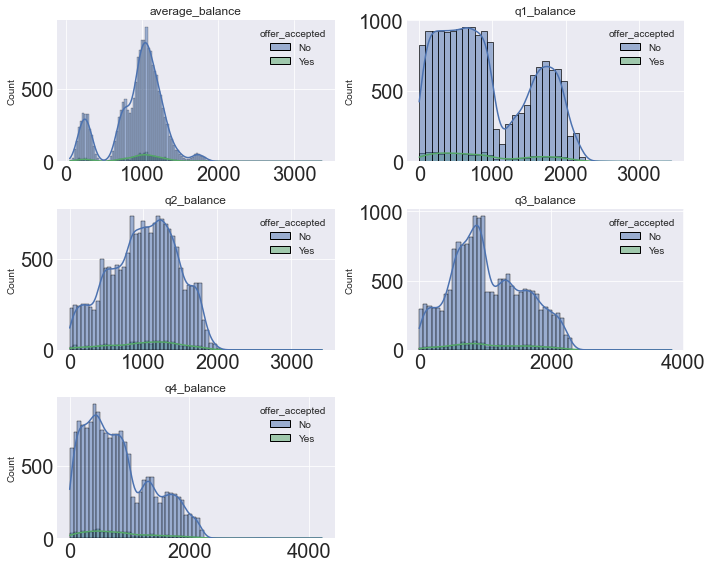

In [282]:
#plot numerical variables distribution
fig, axes = plt.subplots(3, 2, figsize = (10,8))
axes = axes.flat
for i, c in enumerate(columns_num): 
    sns.histplot(data = df, x = c, hue = "offer_accepted", ax = axes[i], kde=True)    
    axes[i].set_title(c)
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    fig.tight_layout()
fig.delaxes(axes[5]);

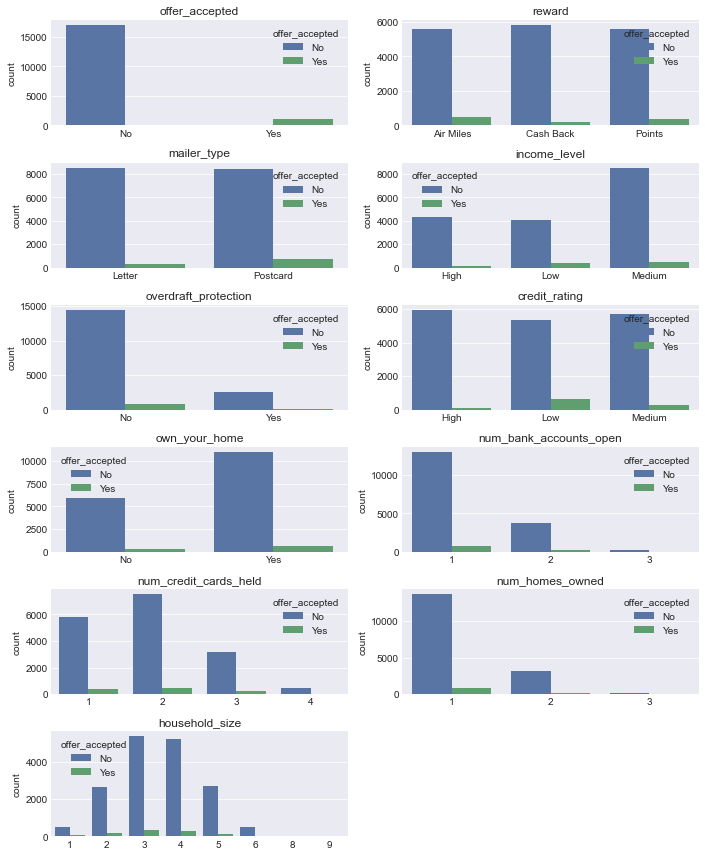

In [283]:
#plot categorical variables distribution
fig, axes = plt.subplots(6, 2, figsize = (10,12))
axes = axes.flat
for i, c in enumerate(columnas_cat): 
    sns.countplot(data = df, x = c, hue = "offer_accepted", ax = axes[i])
    axes[i].set_title(c)
    axes[i].set_xlabel("")
    fig.tight_layout()
fig.delaxes(axes[11]);

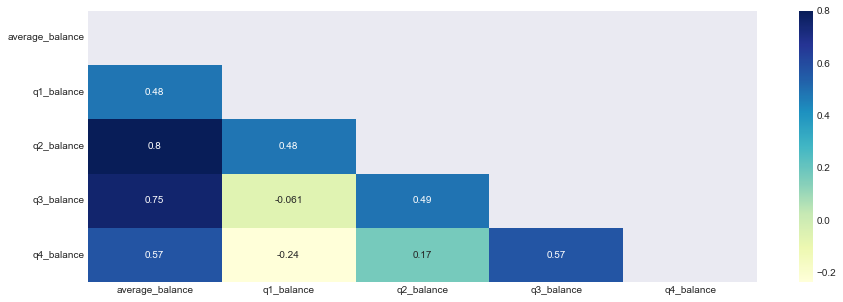

In [284]:
#headmap corr plot
fig, axes = plt.subplots(figsize = (15, 5))
mask = np.triu(np.ones_like(df[columns_num].corr(), dtype = np.bool))
sns.heatmap(df[columns_num].corr(), 
           cmap = "YlGnBu", 
            mask = mask,
           annot = True);

## Outliers

In [285]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
average_balance,18000.0,940.513389,350.061429,48.0,788.00,1006.0,1152.25,3366.0
q1_balance,18000.0,910.450056,619.663515,0.0,393.00,773.0,1520.25,3450.0
q2_balance,18000.0,999.391667,457.097215,0.0,664.00,1032.0,1342.00,3421.0
q3_balance,18000.0,1042.033556,553.083487,0.0,633.00,946.0,1462.00,3823.0
q4_balance,18000.0,810.185556,558.628553,0.0,363.75,704.0,1211.00,4215.0


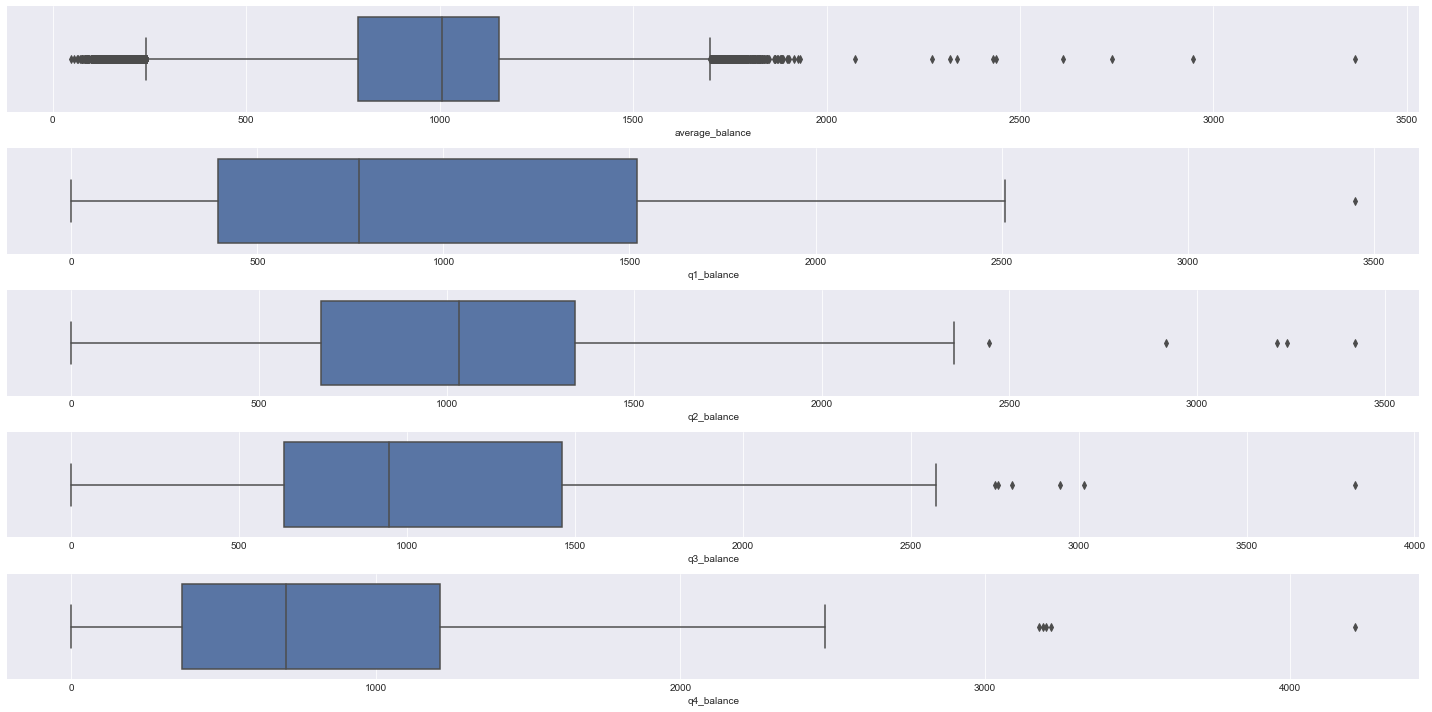

In [286]:
#plot outliers
fig, axes = plt.subplots(5, 1, figsize=(20,10))

for i in range(len(df[columns_num].columns)):
    sns.boxplot(x=df[columns_num].columns[i], data=df[columns_num], ax=axes[i])
    plt.tight_layout()
plt.show();

In [287]:
#get outliers
def find_outliers(columns, dataframe): 
    dicc_indexes = {}
    for col in columns:
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        if outliers_data.shape[0] > 0:
            dicc_indexes[col] = (list(outliers_data.index))    
    return dicc_indexes

outliers = find_outliers(columns_num, df)
outliers_list = []
for k, v in outliers.items():
    print('Column: ', k, '\n', 'Outliers: ', len(v))
    for i in v:
        outliers_list.append(i)
outliers_list = set(outliers_list)
outliers_list = list(outliers_list)
len(outliers_list)

Column:  average_balance 
 Outliers:  1481
Column:  q1_balance 
 Outliers:  1
Column:  q2_balance 
 Outliers:  5
Column:  q3_balance 
 Outliers:  6
Column:  q4_balance 
 Outliers:  5


1482

In [288]:
#drop "No" - substitude "Yes" for mean
print(df.loc[outliers_list]['offer_accepted'].value_counts())
outliers_list_no = df.loc[outliers_list]['offer_accepted'][df.loc[outliers_list]['offer_accepted'] == 'No'].index
outliers_list_yes = df.loc[outliers_list]['offer_accepted'][df.loc[outliers_list]['offer_accepted'] == 'Yes'].index
df_wo_outliers = df.drop(outliers_list_no, axis=0)
avg_balance = df['average_balance'].mean()
for i in outliers_list_yes:
    df_wo_outliers.loc[i, 'average_balance'] = avg_balance

No     1393
Yes      89
Name: offer_accepted, dtype: int64


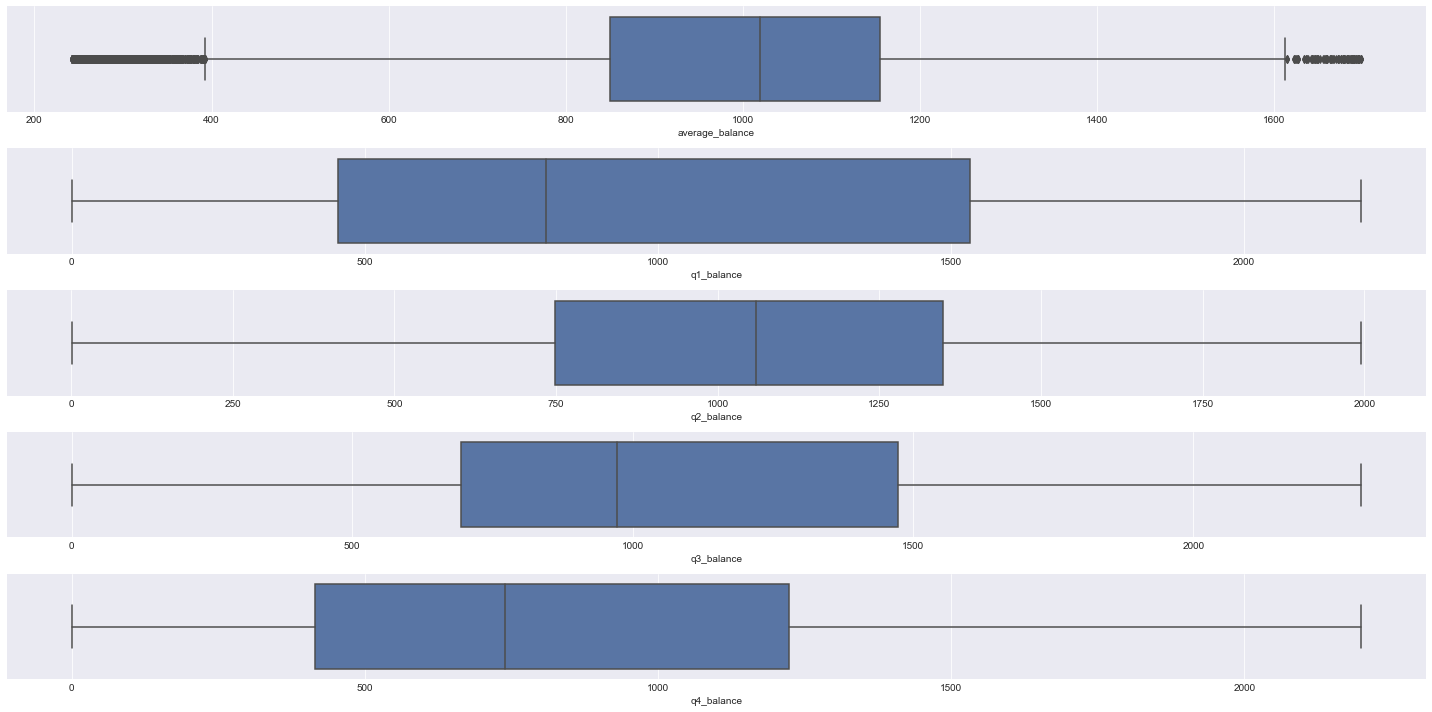

In [289]:
#plot new outliers
fig, axes = plt.subplots(5, 1, figsize=(20,10))
for i in range(len(df_wo_outliers[columns_num].columns)):
    sns.boxplot(x=df_wo_outliers[columns_num].columns[i], data=df_wo_outliers[columns_num], ax=axes[i])
    plt.tight_layout()
plt.show();

## Upsampling minoritary data / downsampling mayoritary data

In [290]:
#unbalanced data sample
df = df_wo_outliers.copy()
data_balance = pd.DataFrame(df.offer_accepted.value_counts())
data_balance['percentage'] = data_balance['offer_accepted']/data_balance['offer_accepted'].sum()
data_balance


,offer_accepted,percentage
No,15584,0.938399
Yes,1023,0.061601


In [291]:
#balance data - downsampling mayoritary class
np.random.seed(10)
remove_n = 13584
df_no = df[df['offer_accepted'] == 'No']
drop_random_index = np.random.choice(df_no.index, remove_n, replace=False)
df = df.drop(drop_random_index)

#balance data - upsampling minoritary class
X = df[df.columns.drop('offer_accepted')]
y = df['offer_accepted']
upp = RandomOverSampler()
X_upp, y_upp = upp.fit_resample(X, y)

data_balanced = pd.DataFrame(y_upp.value_counts())
data_balanced['percentage'] = data_balanced['offer_accepted']/data_balanced['offer_accepted'].sum()
data_balanced

,offer_accepted,percentage
No,2000,0.5
Yes,2000,0.5


In [292]:
#before and after balance plot
fig = plt.figure(figsize=(15,10), dpi=1600)
ax1 = plt.subplot2grid((2,2),(0,0))
plt.pie(data_balance['offer_accepted'], labels = data_balance['offer_accepted'].index, autopct = '%1.1f%%')
plt.title('before balancing')
ax1 = plt.subplot2grid((2,2), (0,1))
plt.pie(data_balanced['offer_accepted'], labels = data_balanced['offer_accepted'].index, autopct = '%1.1f%%')
plt.title('after balancing');

In [293]:
df = pd.concat([y_upp, X_upp], axis=1)
print(df.shape)
df.head(3)

(4000, 16)


,offer_accepted,reward,mailer_type,income_level,num_bank_accounts_open,overdraft_protection,credit_rating,num_credit_cards_held,num_homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
0,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.0,1578,1760,1119,419
1,Yes,Air Miles,Letter,Medium,1,No,Low,1,1,2,No,770.0,54,515,1204,1305
2,No,Points,Postcard,High,1,No,Medium,1,1,1,Yes,690.0,687,554,931,588


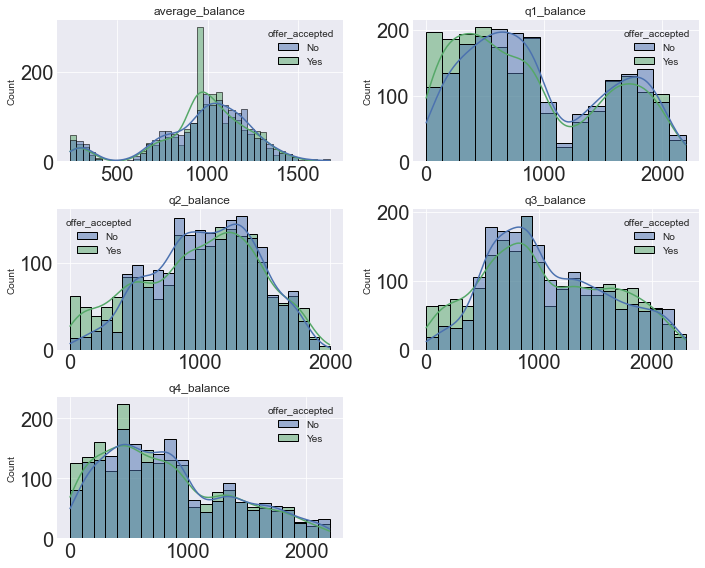

In [294]:
#numerical variables distribution after balancing
fig, axes = plt.subplots(3, 2, figsize = (10,8))
axes = axes.flat
for i, c in enumerate(columns_num): 
    sns.histplot(data = df, x = c, hue = "offer_accepted", ax = axes[i], kde=True)    
    axes[i].set_title(c)
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    fig.tight_layout()
fig.delaxes(axes[5]);

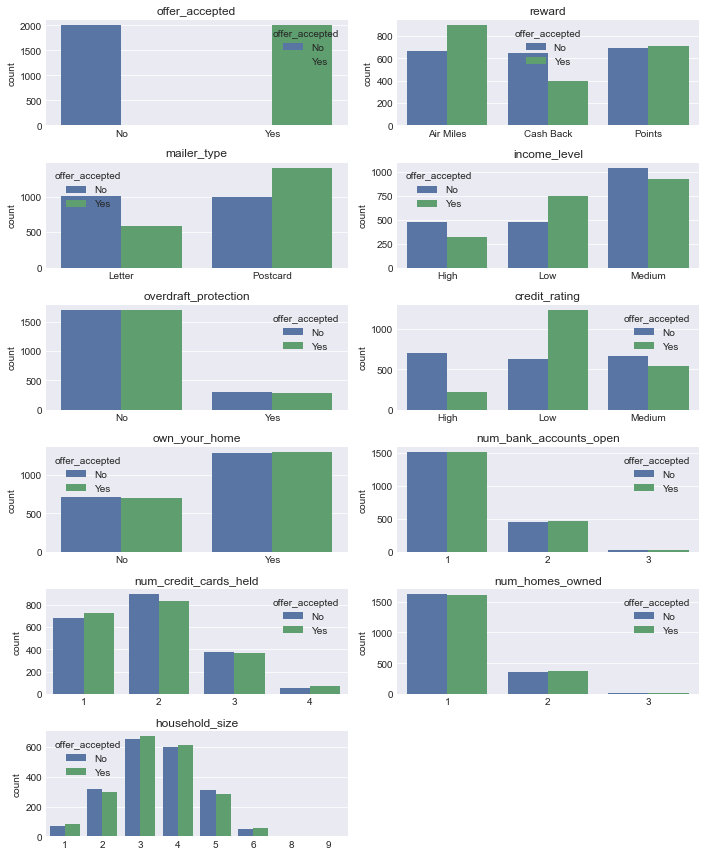

In [295]:
#categorical variables distribution after balancing
fig, axes = plt.subplots(6, 2, figsize = (10,12))
axes = axes.flat
for i, c in enumerate(columnas_cat): 
    sns.countplot(data = df, x = c, hue = "offer_accepted", ax = axes[i])
    axes[i].set_title(c)
    axes[i].set_xlabel("")
    fig.tight_layout()
fig.delaxes(axes[11]);

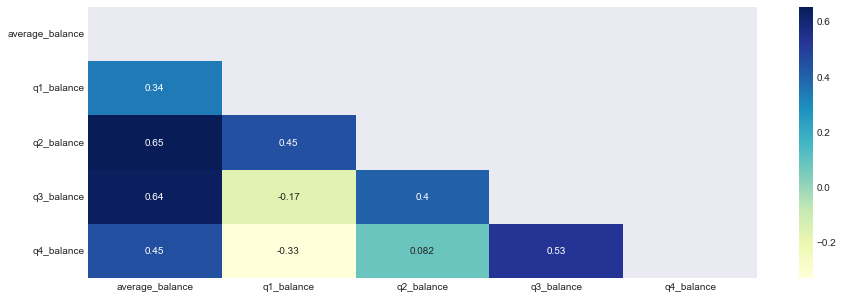

In [296]:
#headmap corr plot after balancing
fig, axes = plt.subplots(figsize = (15, 5))
mask = np.triu(np.ones_like(df[columns_num].corr(), dtype = np.bool))
sns.heatmap(df[columns_num].corr(), 
           cmap = "YlGnBu", 
            mask = mask,
           annot = True);

## Standarization X numeric variables

In [297]:
#standardize numerical data
scaler = StandardScaler()
scaler.fit(df[columns_num])
X_scaler = scaler.transform(df[columns_num])
df[columns_num] = X_scaler
df.head()

,offer_accepted,reward,mailer_type,income_level,num_bank_accounts_open,overdraft_protection,credit_rating,num_credit_cards_held,num_homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
0,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,0.905514,1.071476,1.714157,0.098439,-0.727299
1,Yes,Air Miles,Letter,Medium,1,No,Low,1,1,2,No,-0.765361,-1.411568,-1.153909,0.254970,0.901941
2,No,Points,Postcard,High,1,No,Medium,1,1,1,Yes,-1.063067,-0.380225,-1.064066,-0.247771,-0.416529
3,No,Air Miles,Postcard,Low,3,No,Medium,1,1,4,Yes,-1.174707,-0.334605,-0.898202,-0.588456,-0.484568
4,No,Air Miles,Postcard,Medium,1,No,Medium,2,1,4,No,0.447791,1.540712,0.808816,-0.689741,-0.653744


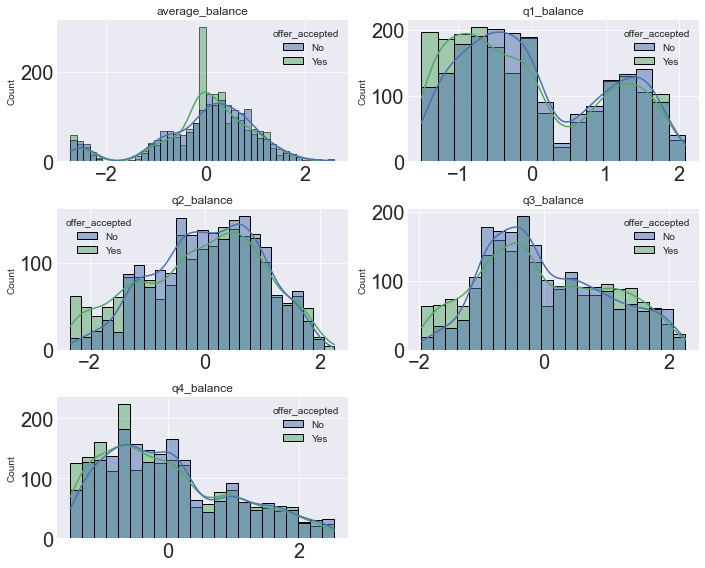

In [299]:
#numerical variables distribution after standardization
fig, axes = plt.subplots(3, 2, figsize = (10,8))
axes = axes.flat
for i, c in enumerate(columns_num): 
    sns.histplot(data = df, x = c, hue = "offer_accepted", ax = axes[i], kde=True)    
    axes[i].set_title(c)
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    fig.tight_layout()
fig.delaxes(axes[5]);

## Encoding categorical variables

In [300]:
columnas_cat

['offer_accepted',
 'reward',
 'mailer_type',
 'income_level',
 'overdraft_protection',
 'credit_rating',
 'own_your_home',
 'num_bank_accounts_open',
 'num_credit_cards_held',
 'num_homes_owned',
 'household_size']

In [301]:
order_offer_accepted = ['No', 'Yes'] 
order_reward = ['Cash Back', 'Points', 'Air Miles']
orden_mail_typer = ["Letter", "Postcard"]
orden_income_level = ["Low", "Medium", "High"]
orden_credit_rating = ["Low", "Medium", "High"]

def ordinal_encoder(orden, df, col):
    ordinal = OrdinalEncoder(categories = [orden], dtype = int)
    transformed_oe = ordinal.fit_transform(df[[col]])
    df[col] = transformed_oe
    return df

In [302]:
df = ordinal_encoder(order_offer_accepted, df, "offer_accepted")
df = ordinal_encoder(order_reward, df, "reward")
df = ordinal_encoder(orden_mail_typer, df, "mailer_type")
df = ordinal_encoder(orden_income_level, df, "income_level")
df = ordinal_encoder(orden_credit_rating, df, "credit_rating")
columns_enc = ['offer_accepted_EN', 'mailer_type_EN', 'income_leve_ENl', 'credit_rating_EN']
df = df.rename(columns = {'offer_accepted': 'offer_accepted_EN', 'reward': 'reward_EN', 'mailer_type': 'mailer_type_EN', 'income_level': 'income_level_EN', 'credit_rating': 'credit_rating_EN'})

dummies = pd.get_dummies(df[["overdraft_protection", 'own_your_home']], prefix_sep = "_", prefix = ["overdraft_protection_EN", 'own_your_home_EN'], dtype = int)
df = pd.concat([df, dummies], axis = 1).drop(["overdraft_protection", 'own_your_home'], axis = 1)
df.head()

,offer_accepted_EN,reward_EN,mailer_type_EN,income_level_EN,num_bank_accounts_open,credit_rating_EN,num_credit_cards_held,num_homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance,overdraft_protection_EN_No,overdraft_protection_EN_Yes,own_your_home_EN_No,own_your_home_EN_Yes
0,0,2,0,1,2,2,1,1,4,0.905514,1.071476,1.714157,0.098439,-0.727299,1,0,1,0
1,1,2,0,1,1,0,1,1,2,-0.765361,-1.411568,-1.153909,0.254970,0.901941,1,0,1,0
2,0,1,1,2,1,1,1,1,1,-1.063067,-0.380225,-1.064066,-0.247771,-0.416529,1,0,0,1
3,0,2,1,0,3,1,1,1,4,-1.174707,-0.334605,-0.898202,-0.588456,-0.484568,1,0,0,1
4,0,2,1,1,1,1,2,1,4,0.447791,1.540712,0.808816,-0.689741,-0.653744,1,0,1,0


## Logistic regression

In [303]:
X = df.drop("offer_accepted_EN", axis = 1) # variables predictoras
y = df["offer_accepted_EN"] # variable respuesta 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 666)

lr = LogisticRegression(max_iter = 100000)
lr.fit(X_train, y_train)
y_test_predict = lr.predict(X_test)
y_train_predict = lr.predict(X_train)

def lr_metrics(y_test, y_test_predict, y_train, y_train_predict, model):
    # para el test
    accuracy_test = accuracy_score(y_test, y_test_predict)
    precision_test = precision_score(y_test, y_test_predict)
    recall_test = recall_score(y_test, y_test_predict)
    f1_test = f1_score(y_test, y_test_predict)
    kappa_test = cohen_kappa_score(y_test, y_test_predict)
    # para el train
    accuracy_train = accuracy_score(y_train, y_train_predict)
    precision_train = precision_score(y_train, y_train_predict)
    recall_train = recall_score(y_train, y_train_predict)
    f1_train = f1_score(y_train, y_train_predict)
    kappa_train = cohen_kappa_score(y_train, y_train_predict)
    
    df = pd.DataFrame({"accuracy": [accuracy_test, accuracy_train], 
                       "precision": [precision_test, precision_train],
                       "recall": [recall_test, recall_train], 
                       "f1": [f1_test, f1_train],
                       "kapppa": [kappa_test, kappa_train],
                       "set": ["test", "train"]})
    df["model"] = model
    return df
results_logistic = lr_metrics(y_test, y_test_predict, y_train, y_train_predict, "Logistic regression")
results_logistic

,accuracy,precision,recall,f1,kapppa,set,model
0,0.703750,0.718009,0.719715,0.718861,0.405784,test,Logistic regression
1,0.695937,0.685208,0.709943,0.697356,0.392055,train,Logistic regression


kappa: es una medida de concordancia que se basa en comparar la concordancia observada en un conjunto de datos, respecto a la que podríaocurrir por mero azar.

<0 No acuerdo

0.0-0.2 Insignificante

0.2-0.4 Bajo

0.4-0.6 Moderado

0.6-0.8 Bueno

0.8-1.0 Muy bueno

In [304]:
#confusion matrix
def matrix(y_test, y_test_predicted, total_test_rows):
    lr = confusion_matrix(y_test, y_test_predicted)

    df = pd.DataFrame(lr, columns = ["offer_not_accepted", "offer_accepted"], index = ["offer_not_accepted", "offer_accepted"])
    df = ((df / total_test_rows) * 100).round(2)
    return df
log_matrix = matrix(y_test, y_test_predict, y_test.shape[0])
log_matrix

,offer_not_accepted,offer_accepted
offer_not_accepted,32.50,14.88
offer_accepted,14.75,37.88


In [305]:
confision_matrix_ex = {'predicted_0_no': ['TN', 'FN'], 'predicted_1_yes': ['FP', 'TP']}
pd.DataFrame(confision_matrix_ex, index=['real_0_no', 'real_1_yes'])
#i'd rather have in this particular case, more FP than FN - less opportunities wasted from mkt pov

,predicted_0_no,predicted_1_yes
real_0_no,TN,FP
real_1_yes,FN,TP


## Calculate importance of every variable

In [308]:
#importance of variables
regressor = DecisionTreeRegressor(random_state = 0) 
regressor.fit(X_train, y_train)
max_features = np.sqrt(len(X_train.columns))
max_features
print(regressor.tree_.max_depth)
y_pred_test_dt = regressor.predict(X_test)
y_pred_train_dt = regressor.predict(X_train)

predictors_importance = pd.DataFrame(
                            {'predictor': X_train.columns,
                             'importance': regressor.feature_importances_}
                            )

predictors_importance.sort_values( ascending=False, by= "importance", inplace=True)
print("predictor model's importance")
print("-------------------------------------------")
predictors_importance

21
predictor model's importance
-------------------------------------------


,predictor,importance
12,q4_balance,0.146788
8,average_balance,0.134638
11,q3_balance,0.130536
10,q2_balance,0.127581
4,credit_rating_EN,0.113526
9,q1_balance,0.095411
0,reward_EN,0.065246
7,household_size,0.047642
1,mailer_type_EN,0.040500
2,income_level_EN,0.034130
